## Counterfactual Explanation on Unstructured Data
### CHAPTER 02 - *Model Explainability Methods*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

In this notebook, we will try to implement some of the concepts related to Counterfactual explanations part of the Example based explainability methods discussed in Chapter 2 - Model Explainability Methods on unstructured image data. Please note that these are some introductory examples, so that beginner learners can also easily execute and learn these approaches. We will particularly try out the Counterfactuals guided by prototypes method as introduced in the research work, [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/abs/1907.02584).

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [1]:
#!pip install --upgrade pandas numpy scikit-learn tensorflow alibi

### Loading the modules

In [34]:
import alibi
from alibi.explainers import CounterfactualProto, Counterfactual
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs  
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as Dataset

In [28]:
# Let's validate the tensorflow version, as otherwise the framework might have some conflicts if it is not supported.
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.1
Eager execution enabled:  False


### About the data

**THE MNIST DATABASE of of handwritten digits**

For this example, we will use the very popular [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which gives us compressed images of hand written digits. The MNIST dataset is one of the most popular dataset for ML and DL beginers which helps the learners to focus mostly on the concept, rather than spending too much time in the data processing and transformation activities. 

### Loading the data

For the purpose of simplicity of understanding, we will use some of the standard examples provided in the original repositories for the Alibi framework. The datasets used might be derived and transformed datasets from original datasets. The sources of the original datasets will be mentioned and I would strongly recommend to look at the original data for more details on the data description and for a more detailed analysis.

In [21]:
mnist_data = Dataset.mnist.load_data()
train_data, test_data = mnist_data
x_train, y_train = train_data
x_test, y_test = test_data

In [22]:
print(f"Shape of training data features:{x_train.shape}")
print(f"Shape of test data features:{x_test.shape}")

Shape of training data features:(60000, 28, 28)
Shape of test data features:(10000, 28, 28)


So, we can see that each image is of dimension (28x28) and there are 60,000 samples for training data and 10,000 samples for test data. Now, let's even visualize some samples.

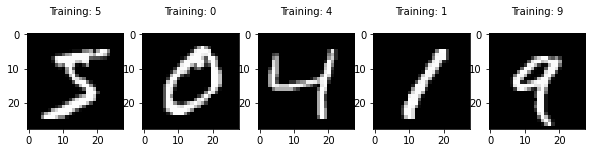

In [23]:
plt.figure(figsize=(10,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 10)

### Data Preparation

Let's prepare the data before modeling it.

In [25]:
x_train = x_train/ 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)

# Using Min-Max Normalizer
MIN, MAX = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (MAX - MIN) + MIN
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (MAX - MIN) + MIN

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)


### Training a CNN model

In [30]:
x_in = Input(shape=(28, 28, 1))
x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x_out = Dense(10, activation='softmax')(x)

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, to_categorical(y_train), batch_size=64, epochs=3, verbose=0)

In [31]:
model.evaluate(x_test, to_categorical(y_test), verbose=0)[1]

0.9005

### Using the Alibi for Counterfactual Explanations for images

Now, let us see how to use the Alibi framework for generating counterfactual examples. We would need to generate a model first, which is supported by the Alibi framework. The Alibi framework will be covered in more details in *Chapter 09 - Other popular XAI frameworks* for other problems which will be slightly more complex. We will apply the guided prototype technique which uses an auto-encoder model. So, let's define the auto-encoder model now.

In [32]:
# Encoder model
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded_features = Conv2D(1, (3, 3), activation=None, padding='same')(x)
encoder = Model(x_in, encoded_features)

In [35]:
# Decoder model
dec_in = Input(shape=(14, 14, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
decoded_features = Conv2D(1, (3, 3), activation=None, padding='same')(x)
decoder = Model(dec_in, decoded_features)

In [36]:
# Autoencoder model
x_out = decoder(encoder(x_in))
autoencoder = Model(x_in, x_out)
autoencoder.compile(optimizer='adam', loss='mse')

In [111]:
# Defining the counterfactual parameters
shape = (1, 28, 28, 1)
gamma = 100.
theta = 100.
c_init = 0.
c_steps = 1
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

In [116]:
# Create the explainer, fit to generate counterfactual examples
def generate_CFE(query_instance):
    '''
    Method to generate counterfactual explanations using the guided prototype method
    '''
    # define a black-box model
    predict_fn = lambda x: model.predict(x)
    
    cf = CounterfactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                             ae_model=autoencoder, enc_model=encoder, max_iterations=max_iterations,
                             feature_range=feature_range, c_init=c_init, c_steps=c_steps)

    cf.fit(x_train)  # find class prototypes
    explanation = cf.explain(query_instance, k=1) # Prototypes defined by knn method
    return explanation

In [117]:
def generate_examples():
    '''
    Function to generate CFE for query instances
    '''
    for i in range(23,24): # Change this value to experiment with other ranges
        plt.subplot(1, 2, 1)
        plt.title('Original Instance:')
        query_instance = x_test[i].reshape((1,) + x_test[i].shape)
        plt.imshow(query_instance.reshape(28, 28));
        explanation = generate_CFE(query_instance)
        print('Counterfactual prediction: {}'.format(explanation.cf['class']))
        print(f'Closest prototype class: {explanation.id_proto}')
        plt.subplot(1, 2, 2)
        plt.title('Generated CFE:')
        plt.imshow(explanation.cf['X'].reshape(28, 28));
        plt.show()

Counterfactual prediction: 6
Closest prototype class: 3


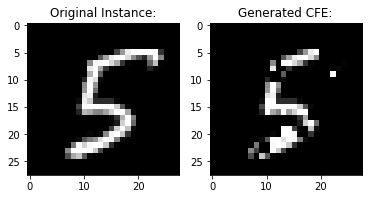

In [118]:
generate_examples()

From the example above we can clearly see that query instance which is for the hand written digit of 5 and after applying the CFE method, predicted the counterfactual outcome as 6. Although the closest prototype is 3. Intuitively speaking, the hand written digit of 5 can look like 6 or 3 depending on the hand-writing style. So, this method was quite interesting.

### Final Thoughts

Implementing example based explainability can be quite challenging for unstructured data. There are many research works of Visual Counterfactual Explanations, but there are very few robust frameworks as of today to implement CFE with unstructured data. Alibi is one of the very few frameworks which I found out to be very interesting. It will be explored in more details in Chapter 9 of the book to tackle other problems. This was just an introductory example to get started with.

### Reference

1. [Alibi](https://github.com/SeldonIO/alibi) - Klaise et. al - Alibi Explain: Algorithms for Explaining Machine Learning Models
2. Some of the utility functions are taken from the GitHub Repository of the author - https://github.com/adib0073